In [479]:
#read the subtitle data
import pandas as pd
sub=pd.read_csv('../input/pa_subtitles.csv')


import warnings
warnings.filterwarnings('ignore')

In [ ]:
#convert the date for each content from string to the datetime python object 
%%time
import datetime
for i in range(sub.shape[0]//7):
    if i%100==0:
        print(i)
    for j in range(7):
        sub['start'][i+j*15091] = datetime.datetime.strptime(sub['start'][i+j*15091], '%H:%M:%S.%f').time() 
        sub['end'][i+j*15091]=datetime.datetime.strptime(sub['end'][i+j*15091], '%H:%M:%S.%f').time() 
        sub['date'][i+j*15091]=datetime.datetime.strptime(sub['date'][i+j*15091], '%Y-%m-%d').date()

sub.to_csv('pa_subtitles.csv',mode='a',index=False,header=False)


**convert the JSON file of the INA subtitles to a dataframe**


In [ ]:
#reading the INA subtitle data (ASR data output) 
import json
tweets = []
for line in open('../input/ina-data/INA_subtitles.json', 'r',encoding="utf-8"):
    tweets.append(json.loads(line))
    

In [ ]:
%%time
import pandas as pd
import datetime
import csv

row = ['content', 'start', 'end','channel','lang','date','duration']
dataf=list()

df=pd.DataFrame()
for i in range(len(tweets)):

    if i%10000==0:
        print(i)
    #row=[]
#         print(i)
#         date_time_str=tweets[i]['segment']['event'][0]['startDate']['$date']
#         row[1]=datetime.datetime.strptime(date_time_str, '%Y-%m-%dT%H:%M:%S.%f+0000').time()
#         enddate=tweets[i]['segment']['event'][0]['endDate']['$date']
#         row[2]=datetime.datetime.strptime(enddate, '%Y-%m-%dT%H:%M:%S.%f+0000').time()
#         row[5]=datetime.datetime.strptime(enddate, '%Y-%m-%dT%H:%M:%S.%f+0000').date()

    for j in range(len(tweets[i]['segment']['text'])):
        date_time_str=tweets[i]['segment']['text'][j]['event'][0]['startDate']
        row[1]=datetime.datetime.strptime(date_time_str, '%Y-%m-%dT%H:%M:%S,%f').time()
        enddate=tweets[i]['segment']['text'][j]['event'][0]['endDate']
        row[2]=datetime.datetime.strptime(enddate, '%Y-%m-%dT%H:%M:%S,%f').time()
        row[0]=tweets[i]['segment']['text'][j]['value']
        row[3]=tweets[i]['segment']['text'][j]['event'][0]['agent'][0]['identifier']
        row[4]=tweets[i]['segment']['text'][j]['lang']
        row[5]=datetime.datetime.strptime(enddate, '%Y-%m-%dT%H:%M:%S,%f').date()
        row[6]=(datetime.datetime.strptime(enddate, '%Y-%m-%dT%H:%M:%S,%f')-datetime.datetime.strptime(date_time_str, '%Y-%m-%dT%H:%M:%S,%f')).total_seconds()

        dataf.append([row[0],row[1],row[2],row[3],row[4],row[5],row[6]])

dat= pd.DataFrame(dataf, columns=['content', 'start', 'end','channel','lang','date','duration'])
dat.to_hdf('INA_subt.hdf', key='abc')#save it as a hdf file

In [ ]:
# import pandas as pd
# data=pd.read_csv('../input/asr-out/test2.csv')

In [ ]:
# data['date'][0]

In [ ]:
# list('AB')

In [599]:
#read data
asr_out= pd.read_hdf('pa_upda.hdf')
ground_truth=pd.read_hdf('INA_subt.hdf')

In [481]:
ground_truth_=ground_truth.sort_values(by='start', ascending=False)[['content','date','duration','start','end','channel']]


In [600]:
asr_out_=asr_out.sort_values(by='start', ascending=True)[['content','date','duration','start','end','dataset']]


In [601]:
diff_chan_gt=ground_truth['channel'].unique()
diff_chan_gt

array(['M6', 'FR3', 'FR2', 'C+', 'TF1', 'ART', 'FR5'], dtype=object)

In [602]:
diff_chan_asr=asr_out_['dataset'].unique()
diff_chan_asr

array(['fit', 'fcr', 'fr2'], dtype=object)

the only common channel for both the asr data and the subtitle data is FR2

<h3>data Preprocessing</h3>

In [603]:

import datetime
#add the hour feature 
ground_truth_['hour_start']=[d.hour for d in ground_truth_['start']]
asr_out_['hour_start']=[d.hour for d in asr_out_['start']]
#add the full date feature (date + time)
asr_out_['full_date']=[datetime.datetime.combine(asr_out_['date'].loc[i], asr_out_['start'].loc[i]) for i in asr_out_.index]
ground_truth_['full_date']=[datetime.datetime.combine(ground_truth_['date'].loc[i], ground_truth_['start'].loc[i]) for i in ground_truth_.index]

In [604]:
asr_out_['hour_start'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [605]:
ground_truth_['hour_start'].unique()

array([23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 11, 10,  9,  8,  7,  6,
        5,  4,  3,  2,  1,  0])

In [606]:
ground_truth_=ground_truth_.reset_index()
asr_out_=asr_out_.reset_index()

In [607]:
ground_truth_['content']=ground_truth_['content']+" "
asr_out_['content']=asr_out_['content']+" "

In [608]:
#keep just the data from the channel fr2
asr_out_fr2=asr_out_.where(asr_out_['dataset']=='fr2').dropna()
ground_truth_fr2=ground_truth_.where(ground_truth_['channel']=='FR2').dropna()

In [610]:
asr_out_fr2.head()

,index,content,date,duration,start,end,dataset,hour_start,full_date
2,104182.0,Attendons et sera pas 100 mètres et c'est exac...,2014-05-19,35.05,00:00:00.100000,00:00:35.600000,fr2,0.0,2014-05-19 00:00:00.100
3,91279.0,"Personne qui travaille sur ce chantier , hé bi...",2014-05-20,42.58,00:00:00.100000,00:00:42.590000,fr2,0.0,2014-05-20 00:00:00.100
6,77657.0,"ça va pas , quand il y a des violences hé ben ...",2014-05-24,6.41,00:00:00.100000,00:00:06.419000,fr2,0.0,2014-05-24 00:00:00.100
7,72510.0,"Même confiance , ça a été un moment extraordin...",2014-05-25,55.40,00:00:00.100000,00:00:55.409000,fr2,0.0,2014-05-25 00:00:00.100
9,103303.0,"Un jeune prince ou roi , une reine juste et ja...",2014-05-22,158.77,00:00:00.100000,00:02:38.780000,fr2,0.0,2014-05-22 00:00:00.100


In [611]:
#group the data by date
grouped_df=ground_truth_.groupby(by=['date'])
tab_gr_date={}
for key, item in grouped_df:
    tab_gr_date[key]=item
    gr=tab_gr_date[key].groupby(by=['channel'])
    t={}
    for k, i in gr:
        t[k]=i
    tab_gr_date[key]=t

grouped_df=asr_out_.groupby(by=['date'])
tab_asr_date={}
for key, item in grouped_df:
    tab_asr_date[key]=item
    gr=tab_asr_date[key].groupby(by=['dataset'])
    t={}
    for k, i in gr:
        t[k]=i
    tab_asr_date[key]=t

In [612]:
import datetime
ground_truth_19=tab_gr_date[datetime.date(2014, 5, 19)]['FR2'].sort_values(by='start',ascending=True)

In [613]:
asr_out_19=tab_asr_date[datetime.date(2014, 5, 19)]['fr2'].sort_values(by='start')

# alignment task by calculating the matching score 

**alignment of the small dataset**

for this step w use data for just one day (2014-05-19)

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

In [614]:
#some useful methods
def add_delta(date,tme, delta):
    # transform to a full datetime first
    return (datetime.datetime.combine(date, tme) + 
            delta)
def minus_delta(date,tme, delta):
    # transform to a full datetime first
    return (datetime.datetime.combine(date, tme) - 
            delta)



In [350]:
from fuzzywuzzy import fuzz
import datetime
from datetime import  timedelta, time
from fuzzywuzzy import process
score=[]
index2=ground_truth_19.index
for i in range(len(index2)):
    T=asr_out_19['full_date'] #get the start full-date of the subtitle data 
    #identify the upper bound
    Tp=add_delta(ground_truth_19.loc[index2[i]]['date'],ground_truth_19.loc[index2[i]]['start'], datetime.timedelta(minutes=2))
    #identify the lower bound
    Tm=minus_delta(ground_truth_19.loc[index2[i]]['date'],ground_truth_19.loc[index2[i]]['start'], datetime.timedelta(minutes=2))
    #get the item to be compared with
    cam_item=asr_out_19.where((T<Tp)&(T>Tm)).dropna()
    index1=cam_item.index
    if i%100==0:
        print(i)
        print(len(index1))
    for j in range(len(index1)):
        
        st1=asr_out_19.loc[index1[j]]['content']
        st2=ground_truth_19.loc[index2[i]]['content']
        score.append([index2[i],index1[j],fuzz.ratio(st1,st2)]) #calclate the matching score

        
matched_text= pd.DataFrame(score, columns=['index_gt','index_asr','score'])
matched_text.to_hdf('matched_text_2min.hdf', key='abc')#save it as a hdf file

0
11
100
15
200
17
300
12
400
13
500
18
600
24
700
16
800
42
900
34
1000
43
1100
15
1200
15
1300
48
1400
21
1500
17
1600
25
1700
21
1800
19
1900
23
2000
35
2100
37
2200
17
2300
26
2400
27
2500
35
2600
16
2700
7
2800
22
2900
15


In [382]:
occ=[]
for i in  set(matched_text.index_gt.to_list()):
    
    idx=matched_text.where(matched_text['index_gt']==i).dropna().score.value_counts().sort_index().tail(1)
    occ.append([i,idx.index.item(),idx.item()])

In [617]:
occ= pd.DataFrame(occ, columns=['index_gt','score','occurence'])
occ.head()

,index_gt,score,occurence
0,90116,38.0,1
1,90125,40.0,3
2,57360,66.0,1
3,90134,39.0,2
4,57372,56.0,1


In [391]:
occ.occurence.value_counts()

1     2648
2      243
3       43
4       17
5        3
10       1
Name: occurence, dtype: int64

**remark:**<br>
given a content from the subtitle data , when using the FuzzyWuzzy matching score, we can find that the best score can be attributed to many pairs. 

In [36]:
#keep the corresponding pairs with the greatest matching score
match_df=matched_text.sort_values('score').drop_duplicates(['index_gt'],keep='last')
match_df=matched_text.sort_values('score').drop_duplicates(['index_asr'],keep='last')



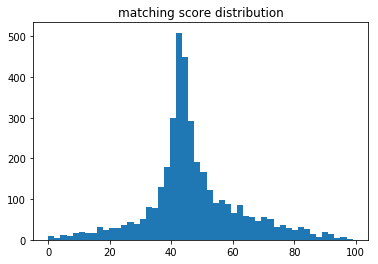

In [40]:
import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(12,6))
# sns.barplot(y=match_df.score.value_counts(), x=match_df.score, data=match_df)
plt.title('matching score distribution');
plt.hist(match_df.score,bins=50);

In [53]:
#set a threshold to accept or not the corresponding pairs
match_df_accept=match_df.where(match_df['score']>60).dropna().sort_values('index_gt')

In [54]:
#keep the aligned data
ground_truth_19.merge(match_df_accept,how='inner',left_index=True,right_on='index_gt').sort_values('index_gt')

,level_0,index,content,date,duration,start,end,channel,hour_start,full_date,index_gt,index_asr,score
68215,185,10109,"L'avantage, c'est un énorme marché. Pour les P...",2014-05-19,108.0,23:56:34,23:58:22,FR2,23,2014-05-19 23:56:34,185.0,105469.0,61.0
68194,217,10105,Sommes-nous menacés par les poulets au chlore?...,2014-05-19,14.0,23:55:56,23:56:10,FR2,23,2014-05-19 23:55:56,217.0,105379.0,75.0
68179,391,10102,Vous reconnaissez donc que ce n'est pas fait.....,2014-05-19,24.0,23:53:07,23:53:31,FR2,23,2014-05-19 23:53:07,391.0,105231.0,70.0
68165,526,10100,Les premières discussions ont commencé 2011. C...,2014-05-19,92.0,23:51:27,23:52:59,FR2,23,2014-05-19 23:51:27,526.0,105130.0,63.0
68157,553,10099,Un énorme dossier s'est invité dans la campagn...,2014-05-19,27.0,23:51:00,23:51:27,FR2,23,2014-05-19 23:51:00,553.0,105110.0,83.0
68148,608,10098,Non. Je ne parle pas que de l'agriculture. On ...,2014-05-19,42.0,23:50:17,23:50:59,FR2,23,2014-05-19 23:50:17,608.0,105067.0,61.0
68025,745,10090,"Dans votre groupe, il y a des députés qui ont ...",2014-05-19,20.0,23:48:10,23:48:30,FR2,23,2014-05-19 23:48:10,745.0,104956.0,65.0
67955,791,10086,"Ce que je propose, c'est faire des modernisati...",2014-05-19,12.0,23:47:35,23:47:47,FR2,23,2014-05-19 23:47:35,791.0,104923.0,66.0
67936,800,10085,"Nous sommes favorables à la PAC, il faut la mo...",2014-05-19,9.0,23:47:26,23:47:35,FR2,23,2014-05-19 23:47:26,800.0,104910.0,69.0
67917,818,10084,"Le vrai problème, c'est la renationalisation d...",2014-05-19,16.0,23:47:10,23:47:26,FR2,23,2014-05-19 23:47:10,818.0,104903.0,62.0


In [55]:
#keep the aligned data
asr_out_.merge(match_df_accept,how='inner',left_index=True,right_on='index_asr').sort_values('index_gt')

,level_0,index,content,date,duration,start,end,dataset,hour_start,full_date,index_gt,index_asr,score
68215,105469,98305,"Je peux vous le dire , assurait jamais faire u...",2014-05-19,68.53,23:57:01.990000,23:58:10.520000,fr2,23,2014-05-19 23:57:01.990,185.0,105469.0,61.0
68194,105379,98302,"Réagissez divers obstacles et je j'ajoute , so...",2014-05-19,12.88,23:55:39.850000,23:55:52.729000,fr2,23,2014-05-19 23:55:39.850,217.0,105379.0,75.0
68179,105231,98299,Et que c'est précisément ce temps qui nous per...,2014-05-19,15.12,23:53:04.700000,23:53:19.190000,fr2,23,2014-05-19 23:53:04.700,391.0,105231.0,70.0
68165,105130,98296,Première réflexion et la discussion a commencé...,2014-05-19,90.91,23:51:11.759000,23:52:42.669000,fr2,23,2014-05-19 23:51:11.759,526.0,105130.0,63.0
68157,105110,98295,C'est à donc un énorme dossier s'est invité da...,2014-05-19,22.81,23:50:48.919000,23:51:11.729000,fr2,23,2014-05-19 23:50:48.919,553.0,105110.0,83.0
68148,105067,98292,Pas Cette industrie agro-alimentaire c'est un ...,2014-05-19,26.16,23:50:04.610000,23:50:30.770000,fr2,23,2014-05-19 23:50:04.610,608.0,105067.0,61.0
68025,104956,98284,Il y a de la réputée qui ont demandé la suppre...,2014-05-19,2.41,23:47:57.350000,23:47:59.759000,fr2,23,2014-05-19 23:47:57.350,745.0,104956.0,65.0
67955,104923,98280,"Construisez dès cette année la est inexact , c...",2014-05-19,7.22,23:47:22.899000,23:47:30.119000,fr2,23,2014-05-19 23:47:22.899,791.0,104923.0,66.0
67936,104910,98278,"Vous avez , nous sommes favorables à la PAC , ...",2014-05-19,5.16,23:47:09.789000,23:47:14.949000,fr2,23,2014-05-19 23:47:09.789,800.0,104910.0,69.0
67917,104903,98276,"On devine le vrai problème c'est la Renault , ...",2014-05-19,4.42,23:46:59.830000,23:47:04.250000,fr2,23,2014-05-19 23:46:59.830,818.0,104903.0,62.0


# alignment data for the channel fr2

In [623]:
import pandas as pd
matched_text= pd.read_hdf('matched_text_fr2.hdf')
#matched_text= pd.read_hdf('../input/matched-content/matched_text.hdf')

In [624]:
match_df=matched_text.sort_values('score').drop_duplicates(['index_gt'],keep='last')
match_df=match_df.sort_values('score').drop_duplicates(['index_asr'],keep='last')



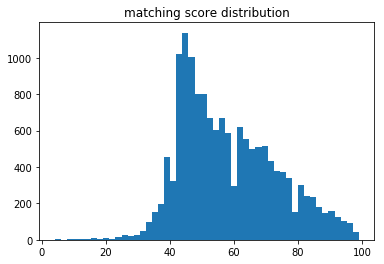

In [625]:
import matplotlib.pyplot as plt

plt.title('matching score distribution');
plt.hist(match_df.score,bins=50);

In [626]:
#set the threshold to accept or not the corresponding pairs to 50
match_df_accept=match_df.where(match_df['score']>50).dropna()

In [627]:
match_df.shape

(15003, 3)

In [503]:
match_df_accept['index_gt']=match_df_accept['index_gt'].astype('int')
match_df_accept['index_asr']=match_df_accept['index_asr'].astype('int')
match_df_accept['score']=match_df_accept['score'].astype('int')

In [504]:
match_df_accept.sort_values('score',ascending=False)

,index_gt,index_asr,score
262646,60823,60254,99
277506,63738,57951,99
395330,74935,34468,99
238951,57986,63492,99
280537,64242,57641,99
281649,64426,57546,99
283536,64775,57360,99
57612,19035,89953,99
281865,64466,57522,99
214426,55154,66484,99


In [505]:
#keep the alignment data
aligned_ground_truth_fr2=ground_truth_fr2.merge(match_df_accept,how='inner',left_index=True,right_on='index_gt').sort_values('index_gt')

In [506]:
#keep the alignment data
aligned_asr_fr2=asr_out_fr2.merge(match_df_accept,how='inner',left_index=True,right_on='index_asr').sort_values('index_gt')

In [509]:
#convert from a dataframe to a csv file
aligned_ground_truth_fr2.to_csv(path_or_buf='aligned_ground_truth_fr2.csv',sep='|',index=False)
aligned_asr_fr2.to_csv(path_or_buf='aligned_asr_fr2.csv',sep='|',index=False)

In [279]:
aligned_ground_truth_fr2

,index,content,date,duration,start,end,channel,hour_start,full_date,index_gt,index_asr,score
11,55726.0,C'est une grande injustice parce que Fignon au...,2014-05-24,3.0,23:59:44,23:59:47,FR2,23.0,2014-05-24 23:59:44,16,105606,61
74,47026.0,"Dans tes sociétés premières bien aimées, est-c...",2014-05-23,10.0,23:59:30,23:59:40,FR2,23.0,2014-05-23 23:59:30,35,105599,62
103,18721.0,On a raconté cet itinéraire jusqu'à ce moment-...,2014-05-21,27.0,23:59:26,23:59:53,FR2,23.0,2014-05-21 23:59:26,43,105607,72
190,55722.0,Non. Parce que j'ai réussi à tuer le père en s...,2014-05-24,16.0,23:59:03,23:59:19,FR2,23.0,2014-05-24 23:59:03,60,105562,55
203,55721.0,Ca ne vous emmerde pas d'avoir un père qui a l...,2014-05-24,5.0,23:58:58,23:59:03,FR2,23.0,2014-05-24 23:58:58,62,105558,80
220,47025.0,"J'aime bien l'anarchisme de Jean-Didier, que j...",2014-05-23,34.0,23:58:56,23:59:30,FR2,23.0,2014-05-23 23:58:56,64,105574,67
238,65262.0,"Emmanuelle Cosse, une dernière remarque... 30%...",2014-05-26,19.0,23:58:56,23:59:15,FR2,23.0,2014-05-26 23:58:56,65,105573,65
255,65261.0,"Je pense que, malheureusement, nous ne sommes ...",2014-05-26,8.0,23:58:48,23:58:56,FR2,23.0,2014-05-26 23:58:48,68,105564,65
273,65260.0,On parle d'une direction provisoire qui serait...,2014-05-26,8.0,23:58:40,23:58:48,FR2,23.0,2014-05-26 23:58:40,71,105556,89
319,47024.0,Ce n'est peut-être pas ça qui va améliorer ce ...,2014-05-23,29.0,23:58:26,23:58:55,FR2,23.0,2014-05-23 23:58:26,79,105539,59


In [280]:
aligned_asr_fr2

,index,content,date,duration,start,end,dataset,hour_start,full_date,index_gt,index_asr,score
11,93913.0,Mais c'est aussi une grande injustice vraiment...,2014-05-24,5.69,23:59:26.100000,23:59:31.789000,fr2,23.0,2014-05-24 23:59:26.100,16,105606,61
74,72135.0,Les premières bien aimé ce qu'il y a est ce qu...,2014-05-23,3.38,23:59:17.589000,23:59:20.970000,fr2,23.0,2014-05-23 23:59:17.589,35,105599,62
103,81312.0,"On a , on a raconté cet itinéraire jusqu'à , j...",2014-05-21,26.72,23:59:26.770000,23:59:53.490000,fr2,23.0,2014-05-21 23:59:26.770,43,105607,72
190,93909.0,"Non , parce que j'ai réussi à tuer le père en ...",2014-05-24,23.56,23:58:31.399000,23:58:54.960000,fr2,23.0,2014-05-24 23:58:31.399,60,105562,55
203,93908.0,"Non , mais pas d'avoir un père qui a l'air si ...",2014-05-24,2.12,23:58:28.589000,23:58:30.710000,fr2,23.0,2014-05-24 23:58:28.589,62,105558,80
220,72134.0,J'aime bien anarchisme de Didier que connaît p...,2014-05-23,32.88,23:58:44.710000,23:59:17.589000,fr2,23.0,2014-05-23 23:58:44.710,64,105574,67
238,105632.0,"Alors Emmanuelle Cosse , une dernière remarque...",2014-05-26,17.76,23:58:43.960000,23:59:01.720000,fr2,23.0,2014-05-26 23:58:43.960,65,105573,65
255,105631.0,"Non , mais je pense d'abord que nous ne sommes...",2014-05-26,7.80,23:58:35.119000,23:58:42.919000,fr2,23.0,2014-05-26 23:58:35.119,68,105564,65
273,105629.0,Une direction provisoire qui serait mis en pla...,2014-05-26,3.97,23:58:23.850000,23:58:27.820000,fr2,23.0,2014-05-26 23:58:23.850,71,105556,89
319,72132.0,"Oui , ce que vous disiez à l'instant , c'est p...",2014-05-23,25.81,23:58:09.869000,23:58:35.679000,fr2,23.0,2014-05-23 23:58:09.869,79,105539,59


In [283]:
#return the remaining data to process it
remaining_asr_out_fr2=asr_out_fr2[~asr_out_fr2['index'].isin(aligned_asr_fr2['index'])]
remaining_ground_truth_fr2=ground_truth_fr2[~ground_truth_fr2['index'].isin(aligned_ground_truth_fr2['index'])]

In [285]:
remaining_asr_out_fr2.to_hdf('remaining_asr_out_fr2.hdf', key='abc')
remaining_ground_truth_fr2.to_hdf('remaining_ground_truth_fr2.hdf', key='abc')

In [529]:
ground_truth_fr2.shape

(24327, 9)

In [528]:
asr_out_fr2.shape

(51387, 9)

In [286]:
remaining_ground_truth_fr2.shape

(15137, 9)

In [287]:
remaining_asr_out_fr2.shape

(42197, 9)

In [288]:
index_gt=aligned_ground_truth_fr2.index
index_asr=aligned_asr_fr2.index
len(index_gt),len(index_asr)

(9190, 9190)

for the first stage we could align 9190/24327 from the subtitle data and 9190/51387 from the asr data

# named entity recognition using spacy 

In [226]:
import spacy
from spacy.lang.fr.examples import sentences 

nlp = fr_core_news_sm.load()
index_gt=aligned_ground_truth_fr2.index
index_asr=aligned_asr_fr2.index
gt_asr_ne=[]
for i in range(len(index_gt)):
    
    doc = nlp(aligned_ground_truth_fr2['content'][index_gt[i]])
    doc1= nlp(aligned_asr_fr2['content'][index_asr[i]])
#     displacy.render(doc, jupyter=True, style='ent')
    ne=[]
    ne1=[]
    score=aligned_ground_truth_fr2['score'][index_gt[i]]
    for token in doc.ents:
#         print(token.text, token.label_)
        ne.append((token.text,token.label_))
    for token in doc1.ents:
#         print(token.text, token.label_)
        ne1.append((token.text,token.label_))
    
    gt_asr_ne.append([doc.text,ne,doc1.text,ne1,score])


In [227]:
df_gt_asr_ne= pd.DataFrame(gt_asr_ne, columns=['gt_content','ne_gt','asr_content','ne_asr','score'])


In [228]:
df_gt_asr_ne.to_hdf('df_gt_asr_ne.hdf', key='abc')

In [230]:
df_gt_asr_ne=pd.read_hdf('df_gt_asr_ne.hdf')

In [565]:
df_gt_asr_ne.sort_values('score',ascending=False).to_csv(path_or_buf='df_gt_asr_ne.csv',sep='|',index=False)

In [551]:
df_gt_asr_ne.sort_values('score',ascending=False)

,gt_content,ne_gt,asr_content,ne_asr,score
1562,Ce n'est pas forcément Adriana qui vous tiendr...,"[(Adriana, PER)]",Ce n'est pas forcément Adriana qui vous tiendr...,"[(Adriana, PER)]",99
6527,"Comme à Quimperlé, les victimes d'inondations ...","[(Quimperlé, LOC)]","Comme à Quimperlé , les victimes d'inondations...","[(Quimperlé, LOC)]",99
4505,Des années pendant lesquelles vous n'avez pas ...,[],Des années pendant lesquelles vous n'avez pas ...,[],99
6519,"Les bureaux de vote sont fermés, Donetsk et sa...","[(Donetsk, LOC)]",Les bureaux de vote sont fermés Donetsk et sa ...,"[(Donetsk, LOC)]",99
6479,"Chaque jour à travers prairies et sous-bois, c...",[],Chaque jour à travers prairies et sous-bois c'...,[],99
6671,Même démarche pour ces candidats qui militent ...,[],Même démarche pour ces candidats qui militent ...,[],99
5847,Il faut maintenant rejoindre les parachutistes...,"[(Bénouville, LOC)]",Il faut maintenant rejoindre les parachutistes...,"[(Bénouville, LOC)]",99
5434,Jessica a donc eu recours à un donneur anonyme...,"[(Jessica, PER), (Sophie, PER)]",Jessica a donc eu recours à un donneur anonyme...,"[(Jessica, PER), (Sophie, PER)]",99
6443,"Demain matin, Jean-François Copé devra rendre ...","[(Jean, PER), (François Copé, PER)]",Demain matin Jean-François Copé devra rendre d...,"[(Jean, PER), (François Copé, PER)]",99
6364,"Le but est aussi de réguler la foule, d'éviter...",[],Le but est aussi de réguler la foule d'éviter ...,[],99


**comparison between the detected named entity from ASR Data and the subtitle Data**

In [567]:
def calcul_occ_ne(data):
    
    ne_occ_gt={'LOC':0,'PER':0,'ORG':0,'MISC':0}
    ne_occ_asr={'LOC':0,'PER':0,'ORG':0,'MISC':0}

    for i in data.index:
        for j in range(len(data.loc[i]['ne_gt'])):
            ne_occ_gt[data.loc[i]['ne_gt'][j][1]]+=1

        for j in range(len(data.loc[i]['ne_asr'])):
            ne_occ_asr[data.loc[i]['ne_asr'][j][1]]+=1
    print('subtitle data \n {}\n asr data \n {}'.format(ne_occ_gt,ne_occ_asr))

In [344]:
# ne_occ_gt={'LOC':0,'PER':0,'ORG':0,'MISC':0}
# ne_occ_asr={'LOC':0,'PER':0,'ORG':0,'MISC':0}

# for i in df_gt_asr_ne.index:
#     for j in range(len(df_gt_asr_ne.loc[i]['ne_gt'])):
#         ne_occ_gt[df_gt_asr_ne.loc[i]['ne_gt'][j][1]]+=1
        
#     for j in range(len(df_gt_asr_ne.loc[i]['ne_asr'])):
#         ne_occ_asr[df_gt_asr_ne.loc[i]['ne_asr'][j][1]]+=1

In [628]:
calcul_occ_ne(df_gt_asr_ne)

subtitle data 
 {'LOC': 5322, 'PER': 4375, 'ORG': 1056, 'MISC': 1420}
 asr data 
 {'LOC': 5409, 'PER': 4836, 'ORG': 1306, 'MISC': 1357}


In [568]:
#coparison when the score is gretaer than 90
ne90=df_gt_asr_ne.where((df_gt_asr_ne['score']>=90)&(df_gt_asr_ne['score']<=100)).dropna().sort_values('score',ascending=False)
calcul_occ_ne(ne90)

subtitle data 
 {'LOC': 212, 'PER': 160, 'ORG': 39, 'MISC': 34}
 asr data 
 {'LOC': 210, 'PER': 158, 'ORG': 41, 'MISC': 42}


In [562]:
ne80=df_gt_asr_ne.where((df_gt_asr_ne['score']>=80)&(df_gt_asr_ne['score']<=90)).dropna().sort_values('score',ascending=False)
calcul_occ_ne(ne80)

{'LOC': 545, 'PER': 483, 'ORG': 142, 'MISC': 117} {'LOC': 563, 'PER': 532, 'ORG': 148, 'MISC': 101}


In [467]:
ne_list_gt={'LOC':[],'PER':[],'ORG':[],'MISC':[]}
ne_list_asr={'LOC':[],'PER':[],'ORG':[],'MISC':[]}

for i in df_gt_asr_ne.index:
    for j in range(len(df_gt_asr_ne.loc[i]['ne_gt'])):

        ne_list_gt[df_gt_asr_ne.loc[i]['ne_gt'][j][1]].append(df_gt_asr_ne.loc[i]['ne_gt'][j][0])
        
    for j in range(len(df_gt_asr_ne.loc[i]['ne_asr'])):

        ne_list_asr[df_gt_asr_ne.loc[i]['ne_asr'][j][1]].append(df_gt_asr_ne.loc[i]['ne_asr'][j][0])
        

In [587]:
ne_list_gt,ne_list_asr

({'LOC': ['Pygmées',
   'mont Blanc',
   'Ca',
   'Etat',
   'Etat',
   'Etat',
   'Europe',
   'de France',
   'Rika',
   'Français',
   'France',
   'Européens',
   'Américains',
   'Européens',
   'de France',
   'Porto Rico',
   'Belmondo',
   'Malkovich',
   'Japonais',
   'Etat',
   'Bonjour',
   'Cristiana',
   'Japonais',
   'Votre',
   'Gaîté Montparnasse',
   'Paris',
   'Molières',
   'Terre',
   'Sonneries',
   'Japon',
   'Suisse',
   'Regardez-moi',
   'Cristiana',
   'Tiens',
   'Europe',
   'de France',
   "l'Europe",
   'Français',
   'Dimanche',
   'Kazakhstan',
   'Japon',
   'Américains',
   "l'Olympia",
   'Nostalgie',
   'Monte-Carlo',
   'Paris',
   'Suède',
   'Autrichiens',
   'Italie',
   'Hollandais',
   "l'Europe",
   'La France',
   'France',
   'Europe',
   'Osaka',
   'du Japon',
   'Votre',
   'Bruxelles',
   'Rires',
   'Bruxelles',
   'Comédie',
   'Française',
   'Ouest',
   'Coldplay',
   'France',
   'Alcaline',
   'Alcaline',
   'Eden',
   'Juan-le

In [598]:
import json
with open('ne_list_gt.json', 'w',encoding='utf-8') as fp:
    json.dump(ne_list_gt, fp,ensure_ascii=False)

with open('ne_list_asr.json', 'w',encoding='utf-8') as fp:
    json.dump(ne_list_asr, fp,ensure_ascii=False)

# text matching for the remaining data 

In [533]:
remaining_matched_text_fr2=pd.read_hdf('remaining_matched_text_fr2.hdf')

In [534]:
remaining_matched_text_fr2

,index_gt,index_asr,score
9785057,80769,11771,1
9794580,80829,11101,2
9785060,80769,11795,3
9794584,80829,11740,4
9269262,76576,18453,4
9269267,76576,18490,5
9753629,80599,11922,5
9794581,80829,11654,5
9817650,81076,11441,5
9785059,80769,11792,6


In [535]:

remain_match_df=remaining_matched_text_fr2.sort_values('score').drop_duplicates(['index_asr'],keep='last')


In [536]:
remain_match_df=remaining_matched_text_fr2.sort_values('score').drop_duplicates(['index_gt'],keep='last')


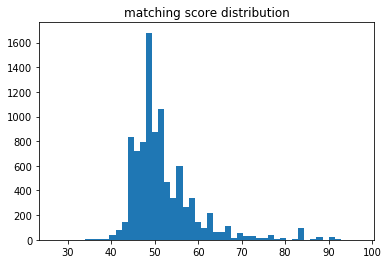

In [537]:
import matplotlib.pyplot as plt

plt.title('matching score distribution');
plt.hist(remain_match_df.score,bins=50);

In [538]:
remain_match_df_accept=remain_match_df.where(remain_match_df.score>60).dropna()

In [539]:
remain_match_df_accept.index_gt=remain_match_df_accept.index_gt.astype('int')
remain_match_df_accept.index_asr=remain_match_df_accept.index_asr.astype('int')
remain_match_df_accept.score=remain_match_df_accept.score.astype('int')

In [540]:
remain_match_df_accept

,index_gt,index_asr,score
7641216,70043,48468,61
9539269,79111,5261,61
4495619,52569,72824,61
2214286,30374,83423,61
2375459,31546,79751,61
713965,6096,98131,61
643003,5605,93601,61
10925897,86618,99677,61
3754425,45596,81784,61
11732429,89276,8577,61


In [541]:
remain_aligned_ground_truth_fr2=remaining_ground_truth_fr2.merge(remain_match_df_accept,how='inner',left_index=True,right_on='index_gt').sort_values('index_gt')

In [542]:
remain_aligned_asr_out_fr2=remaining_asr_out_fr2.merge(remain_match_df_accept,how='inner',left_index=True,right_on='index_asr').sort_values('index_gt')

In [546]:
remain_aligned_ground_truth_fr2.to_csv(path_or_buf='remain_aligned_ground_truth_fr2.csv',sep='|',index=False)
remain_aligned_asr_out_fr2.to_csv(path_or_buf='remain_aligned_asr_out_fr2.csv',sep='|',index=False)

In [543]:
remain_aligned_ground_truth_fr2

,index,content,date,duration,start,end,channel,hour_start,full_date,index_gt,index_asr,score
2200,63067.0,"Moi, j'en veux un. ...",2014-05-20,17.0,23:59:35,23:59:52,FR2,23.0,2014-05-20 23:59:35,30,162,61
38069,18696.0,Vous avez un bon souvenir de lui ?,2014-05-21,1.0,23:55:30,23:55:31,FR2,23.0,2014-05-21 23:55:30,244,962,64
42120,63053.0,C'est pour la 602.,2014-05-20,2.0,23:55:13,23:55:15,FR2,23.0,2014-05-20 23:55:13,260,3436,63
45186,63049.0,Je suis sûr que ça va.,2014-05-20,2.0,23:54:51,23:54:53,FR2,23.0,2014-05-20 23:54:51,279,103672,62
49320,63046.0,"Non, pas vraiment, je les laisse faire.",2014-05-20,5.0,23:54:36,23:54:41,FR2,23.0,2014-05-20 23:54:36,299,104383,64
57016,18684.0,C'est un handicap.,2014-05-21,2.0,23:53:04,23:53:06,FR2,23.0,2014-05-21 23:53:04,393,4815,67
99659,65230.0,Ce n'est pas vrai...,2014-05-26,10.0,23:48:58,23:49:08,FR2,23.0,2014-05-26 23:48:58,699,97229,63
127755,55666.0,"De ma part, non.",2014-05-24,2.0,23:45:07,23:45:09,FR2,23.0,2014-05-24 23:45:07,953,98614,67
136606,55663.0,Elle en avait un petit peu marre.,2014-05-24,4.0,23:44:14,23:44:18,FR2,23.0,2014-05-24 23:44:14,1022,99899,63
143481,10077.0,Ce n'est pas une réalité.,2014-05-19,3.0,23:43:43,23:43:46,FR2,23.0,2014-05-19 23:43:43,1056,98075,62


In [544]:
remain_aligned_asr_out_fr2

,index,content,date,duration,start,end,dataset,hour_start,full_date,index_gt,index_asr,score
2200,95202.0,Moi je je .,2014-05-21,1.17,00:02:54.280000,00:02:55.449000,fr2,0.0,2014-05-21 00:02:54.280,30,162,61
38069,103357.0,"Vous avez non , on est là pour obéir .",2014-05-22,2.29,00:16:03.590000,00:16:05.879000,fr2,0.0,2014-05-22 00:16:03.590,244,962,64
42120,95452.0,C'est dur un du .,2014-05-21,9.58,00:58:04.789000,00:58:14.369000,fr2,0.0,2014-05-21 00:58:04.789,260,3436,63
45186,88708.0,Je crois que .,2014-05-20,0.92,23:26:33.390000,23:26:33.960000,fr2,23.0,2014-05-20 23:26:33.390,279,103672,62
49320,88760.0,Nous pouvons rester désunie et laisser faire .,2014-05-20,2.18,23:38:04.160000,23:38:06.339000,fr2,23.0,2014-05-20 23:38:04.160,299,104383,64
57016,61380.0,Et c'est une chance .,2014-05-22,2.36,01:18:37.579000,01:18:39.940000,fr2,1.0,2014-05-22 01:18:37.579,393,4815,67
99659,83305.0,C'est pas encore .,2014-05-26,1.22,21:55:18.970000,21:55:20.190000,fr2,21.0,2014-05-26 21:55:18.970,699,97229,63
127755,72398.0,De comme ça non .,2014-05-24,2.88,22:16:16.160000,22:16:19.390000,fr2,22.0,2014-05-24 22:16:16.160,953,98614,67
136606,72443.0,On a un petit peu plus .,2014-05-24,1.12,22:32:45.570000,22:32:46.690000,fr2,22.0,2014-05-24 22:32:45.570,1022,99899,63
143481,95525.0,Accents pas traité .,2014-05-19,6.55,22:07:47.880000,22:07:54.429000,fr2,22.0,2014-05-19 22:07:47.880,1056,98075,62


In [442]:
import spacy
from spacy.lang.fr.examples import sentences 

nlp = fr_core_news_sm.load()
index_gt=remain_aligned_ground_truth_fr2.index
index_asr=remain_aligned_asr_out_fr2.index
r_gt_asr_ne=[]
for i in range(len(index_gt)):
    
    doc = nlp(remain_aligned_ground_truth_fr2['content'][index_gt[i]])
    doc1= nlp(remain_aligned_asr_out_fr2['content'][index_asr[i]])
#     displacy.render(doc, jupyter=True, style='ent')
    ne=[]
    ne1=[]
    score=remain_aligned_ground_truth_fr2['score'][index_gt[i]]
    for token in doc.ents:
#         print(token.text, token.label_)
        ne.append((token.text,token.label_))
    for token in doc1.ents:
#         print(token.text, token.label_)
        ne1.append((token.text,token.label_))
    
    r_gt_asr_ne.append([doc.text,ne,doc1.text,ne1,score])

In [443]:
r_df_gt_asr_ne= pd.DataFrame(r_gt_asr_ne, columns=['gt_content','ne_gt','asr_content','ne_asr','score'])


In [548]:
r_df_gt_asr_ne.sort_values('score',ascending=False).where(r_df_gt_asr_ne.score>60).dropna()

,gt_content,ne_gt,asr_content,ne_asr,score
45,Je suis agréablement surpris.,[],Je suis agréablement surpris .,[],97
231,Marie-Pascale.,"[(Marie, PER), (Pascale, PER)]",Marie-Pascale .,"[(Marie, PER), (Pascale, PER)]",94
592,Tout à fait.,[],Tout à fait .,[],93
917,Très bien.,[],Très bien .,[],92
584,Très bien.,[],Très bien .,[],92
519,Attention.,[],Attention .,[],92
208,"Attention,",[],Attention .,[],92
161,C'est vrai.,[],C'est vrai .,[],92
770,C'est vrai.,[],C'est vrai .,[],92
884,D'accord.,[],D'accord .,[],91


In [566]:
r_df_gt_asr_ne.sort_values('score',ascending=False).to_csv(path_or_buf='r_df_gt_asr_ne.csv',sep='|',index=False)


In [455]:
r_ne_occ_gt={'LOC':[0,[]],'PER':[0,[]],'ORG':[0,[]],'MISC':[0,[]]}
r_ne_occ_asr={'LOC':[0,[]],'PER':[0,[]],'ORG':[0,[]],'MISC':[0,[]]}

for i in r_df_gt_asr_ne.index:
    for j in range(len(r_df_gt_asr_ne.loc[i]['ne_gt'])):
        r_ne_occ_gt[r_df_gt_asr_ne.loc[i]['ne_gt'][j][1]][0] +=1
        r_ne_occ_gt[r_df_gt_asr_ne.loc[i]['ne_gt'][j][1]][1].append(r_df_gt_asr_ne.loc[i]['ne_gt'][j][0])
        
    for j in range(len(r_df_gt_asr_ne.loc[i]['ne_asr'])):
        r_ne_occ_asr[r_df_gt_asr_ne.loc[i]['ne_asr'][j][1]][0]+=1
        r_ne_occ_asr[r_df_gt_asr_ne.loc[i]['ne_asr'][j][1]][1].append(r_df_gt_asr_ne.loc[i]['ne_asr'][j][0])
        

In [460]:
r_ne_occ_gt['ORG']

[4, ['Faut', 'Yes', 'FESTIVAL', 'The Cure']]

In [569]:
calcul_occ_ne(r_df_gt_asr_ne)

subtitle data 
 {'LOC': 75, 'PER': 43, 'ORG': 4, 'MISC': 28}
 asr data 
 {'LOC': 48, 'PER': 43, 'ORG': 6, 'MISC': 17}


In [572]:
r_asr_out_fr2=remaining_asr_out_fr2[~remaining_asr_out_fr2['index'].isin(remain_aligned_asr_out_fr2['index'])]

In [578]:
r_asr_out_fr2

,index,content,date,duration,start,end,dataset,hour_start,full_date
2,104182.0,Attendons et sera pas 100 mètres et c'est exac...,2014-05-19,35.05,00:00:00.100000,00:00:35.600000,fr2,0.0,2014-05-19 00:00:00.100
3,91279.0,"Personne qui travaille sur ce chantier , hé bi...",2014-05-20,42.58,00:00:00.100000,00:00:42.590000,fr2,0.0,2014-05-20 00:00:00.100
6,77657.0,"ça va pas , quand il y a des violences hé ben ...",2014-05-24,6.41,00:00:00.100000,00:00:06.419000,fr2,0.0,2014-05-24 00:00:00.100
7,72510.0,"Même confiance , ça a été un moment extraordin...",2014-05-25,55.40,00:00:00.100000,00:00:55.409000,fr2,0.0,2014-05-25 00:00:00.100
9,103303.0,"Un jeune prince ou roi , une reine juste et ja...",2014-05-22,158.77,00:00:00.100000,00:02:38.780000,fr2,0.0,2014-05-22 00:00:00.100
11,95189.0,"Bonjour , vous avez des sous-vêtements sexy , ...",2014-05-21,6.16,00:00:00.100000,00:00:06.169000,fr2,0.0,2014-05-21 00:00:00.100
12,87858.0,Uniquement à charge .,2014-05-26,1.38,00:00:00.180000,00:00:01.560000,fr2,0.0,2014-05-26 00:00:00.180
17,87859.0,"C'est un désastre , dire : c'est une , ça n'es...",2014-05-26,22.78,00:00:05.490000,00:00:27.829000,fr2,0.0,2014-05-26 00:00:05.490
19,77658.0,"L'économie le de la famille de l'État , c'est ...",2014-05-24,25.46,00:00:08.199000,00:00:33.659000,fr2,0.0,2014-05-24 00:00:08.199
20,95190.0,Je vous envoie une capsule un instant .,2014-05-21,2.69,00:00:08.410000,00:00:11.990000,fr2,0.0,2014-05-21 00:00:08.410


In [574]:
r_ground_truth_fr2=remaining_ground_truth_fr2[~remaining_ground_truth_fr2['index'].isin(remain_aligned_ground_truth_fr2['index'])]

In [586]:
r_ground_truth_fr2

,index,content,date,duration,start,end,channel,hour_start,full_date
17,47028.0,Justement!,2014-05-23,13.0,23:59:43,23:59:56,FR2,23.0,2014-05-23 23:59:43
23,55725.0,Oui. Fignon et LeMond ont fini à 8s d'écart.,2014-05-24,4.0,23:59:40,23:59:44,FR2,23.0,2014-05-24 23:59:40
24,47027.0,Je connais mieux que toi les tribus!,2014-05-23,3.0,23:59:40,23:59:43,FR2,23.0,2014-05-23 23:59:40
40,63066.0,Un enfant ? Ce serait spécial.,2014-05-20,8.0,23:59:27,23:59:35,FR2,23.0,2014-05-20 23:59:27
46,55724.0,C'est un livre très agréable à feuilleter. On ...,2014-05-24,20.0,23:59:20,23:59:40,FR2,23.0,2014-05-24 23:59:20
47,55723.0,Un mot sur le livre ?,2014-05-24,1.0,23:59:19,23:59:20,FR2,23.0,2014-05-24 23:59:19
52,18720.0,"Et peu de temps après, Jennifer Lopez a rompu ...",2014-05-21,10.0,23:59:16,23:59:26,FR2,23.0,2014-05-21 23:59:16
55,18719.0,C'était la bonne.,2014-05-21,3.0,23:59:13,23:59:16,FR2,23.0,2014-05-21 23:59:13
56,63065.0,Ils ont l'air si heureux. Tu veux avoir un enf...,2014-05-20,16.0,23:59:11,23:59:27,FR2,23.0,2014-05-20 23:59:11
58,10113.0,Comme toi qui sors ta casquette écologique...,2014-05-19,2.0,23:59:09,23:59:11,FR2,23.0,2014-05-19 23:59:09


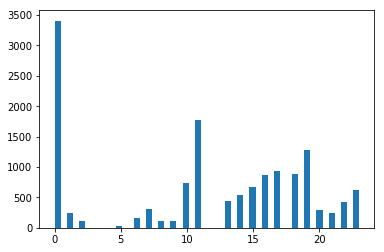

In [585]:
plt.hist(r_ground_truth_fr2.hour_start,bins=50);